In [1]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import cv2
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
import sklearn
import codecs, json 
import scipy.io
import h5py
import pandas as pd

device=torch.device("cuda:0")

# Import topnet utilities
import sys
sys.path.insert(0, '/home/ephy/Projects/tda_convolution/src/')
import topnet
import importlib
importlib.reload(topnet)

<module 'topnet' from '/home/ephy/Projects/tda_convolution/src/topnet.py'>

In [2]:
datadir='/home/ephy/Projects/tda_convolution/data/original/SVHN/'
trainmat = scipy.io.loadmat(datadir+'train_32x32.mat')
testmat = scipy.io.loadmat(datadir+'test_32x32.mat')

In [3]:
# Resize to MNIST and change to grayscale
X=list()
for i in range(trainmat['X'].shape[3]):
    X.append(cv2.resize(trainmat['X'][...,i], (28,28)))
    
for i in range(testmat['X'].shape[3]):
    X.append(cv2.resize(testmat['X'][...,i], (28,28)))
    
# X=torch.tensor(np.dot(X[...,:3], [0.299, 0.587, 0.114]), dtype=torch.float32).view(-1,1,32,32)
X=np.dot((np.array(X)/255)[...,:3], [0.299, 0.587, 0.114])

In [4]:
train_y = np.array(trainmat['y']).flatten()
test_y = np.array(testmat['y']).flatten()
y=np.append(train_y,test_y)
classes=len(np.unique(y))
y[y==10]=0 # swtich coding of classes

In [5]:
y_ballanced=list()
X_ballanced=list()

n = np.arange(np.min(np.histogram(np.array(y))[0]))
np.random.shuffle(n)
for i in range(classes):
    y_ballanced.append(y[y==(i)][n])
    X_ballanced.append(X[y==(i)][n])
    
X_ballanced = np.array(X_ballanced)
X_ballanced = X_ballanced.reshape(np.product(X_ballanced.shape[0:2]),X_ballanced.shape[2],X_ballanced.shape[3])
y_ballanced = np.array(y_ballanced)
y_ballanced = y_ballanced.reshape(np.product(y_ballanced.shape[0:2]))

In [6]:
train_X , test_X , train_y , test_y = train_test_split(X_ballanced , y_ballanced, 
                                                test_size = 0.2 ,
                                                random_state = 1)

In [7]:
classes=list(range(10))
train_X = torch.tensor(train_X,  dtype=torch.float32)
test_X = torch.tensor(test_X,  dtype=torch.float32)
train_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in train_y]), dtype=torch.float32)
test_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in test_y]), dtype=torch.float32)

In [8]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'

train = datasets.MNIST(datadir+"original/", train=True, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(datadir+"original/", train=True, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))

In [9]:
mnist_train_X = torch.tensor([np.array(i[0]) for i in train])
mnist_test_X = torch.tensor([np.array(i[0]) for i in test])
mnist_train_y = [i[1] for i in train]
mnist_test_y = [i[1] for i in test]

In [10]:
classes=np.unique(mnist_train_y)
mnist_test_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in mnist_test_y], dtype=torch.float32)
mnist_train_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in mnist_train_y], dtype=torch.float32)

In [11]:
from skimage.filters import gabor_kernel

In [12]:
kernels = gabor_kernel(frequency=0.2, bandwidth=0.1)

In [13]:
#bigger
sigs=list(range(1,6))
thes=list(range(1,4))
lams=[10]
gams=[0]
phis=list(range(0,5))

In [2]:
#smaller
sigs=list(range(1,4))
thes=list(range(1,4))
lams=[10]
gams=[0,10]
phis=list(range(0,4))

In [15]:
# #smaller
# sigs=list(range(1,6))
# thes=list(range(1,4))
# lams=[10]
# gams=[0,10]
# phis=list(range(0,4))

In [3]:
kernels = np.array([cv2.getGaborKernel((3,3),sig, the, lam, gam, phi, cv2.CV_32F) for sig in sigs for the in thes for lam in lams for gam in gams for phi in phis])

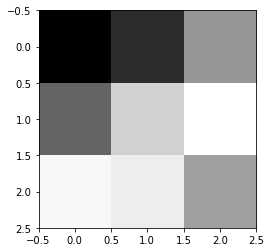

In [7]:
plt.imshow(kernels[1], cmap='gray')

In [18]:
configs=dict()
config = dict()
config['weights_config']=[[('Gabor',3)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,72,3),(72,72,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=len(classes)
config['imageDim']=(28,28)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['Gabor + NOL'] = config

config = dict()
config['weights_config']=[[('Klein',9,8,3,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,72,3),(72,72,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=len(classes)
config['imageDim']=(28,28)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + NOL'] = config

config = dict()
config['weights_config']=[None,None]
config['freeze_layers']=[False,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,72,3),(72,72,3)]
config['pools']=[None,None]
config['activations']=['F.relu', 'F.relu']
config['learning_rate']=1e-5
config['classes']=len(classes)
config['imageDim']=(28,28)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=1
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + NOL'] = config

In [19]:
# results=dict()
results['SVHN'] = topnet.run_configs(configs, None)

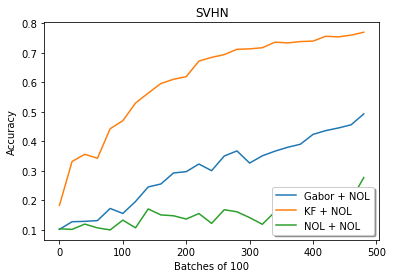

In [20]:
dataset='SVHN'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [21]:
mnist_configs = copy.deepcopy(configs)
for key, config in mnist_configs.items():
    config['classes']=len(classes)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X
    config['batchesPerTest']=20
    config['dataset']='MNIST'

In [22]:
results['MNIST'] = topnet.run_configs(mnist_configs, None)

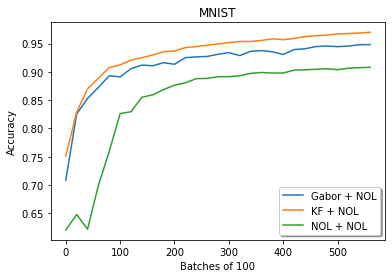

In [23]:
dataset='MNIST'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [24]:
classes=list(range(10))
with h5py.File('/home/ephy/Projects/tda_convolution/data/original/USPS/usps.h5', 'r') as hf:
        usps_train_X = hf.get('train').get('data')[:]
        usps_train_y = hf.get('train').get('target')[:]
        usps_test_X = hf.get('test').get('data')[:]
        usps_test_y = hf.get('test').get('target')[:]
        
usps_train_X = torch.tensor(usps_train_X.reshape(-1,16,16), dtype=torch.float32)
usps_test_X = torch.tensor(usps_test_X.reshape(-1,16,16), dtype=torch.float32)
usps_train_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in usps_train_y]), dtype=torch.float32)
usps_test_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in usps_test_y]), dtype=torch.float32)


In [25]:
usps_configs = copy.deepcopy(configs)
for key, config in usps_configs.items():
    config['classes']=len(classes)
    config['imageDim']=(16,16)
    config['test_X']=usps_test_X
    config['test_y']=usps_test_y
    config['train_y']=usps_train_y
    config['train_X']=usps_train_X
    config['batchesPerTest']=5
    config['dataset']='USPS'

In [26]:
results['USPS'] = topnet.run_configs(usps_configs, None)

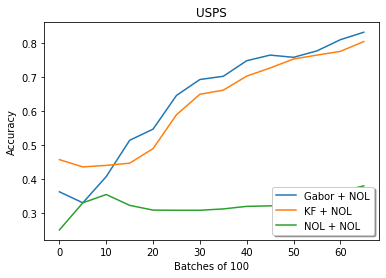

In [27]:
dataset='USPS'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [28]:
datasets = ['MNIST', 'SVHN', 'USPS']
accdat = dict()
for dataset in datasets:
    configuration=results[dataset]
    acc_2000=[]
    for name, item in configuration.items():
        acc_2000.append(item['accuracies'][int(2000/(item['config']['batchesPerTest']*item['config']['batchSize']) - 1)])
    accdat[dataset]=acc_2000
dataset=datasets[2]
configuration=results[dataset]
acc_2000_2=[]
names=[]
for name, item in configuration.items():
    names.append(name)

In [29]:
df = pd.DataFrame(data=accdat)
df = df.transpose()
df.columns =names

In [30]:
df = df[['KF + NOL', 'Gabor + NOL', 'NOL + NOL']]

In [31]:
colordict={'KF + COL': '#de6eeb','NOL + NOL': '#1f77b4', 'KF + KOL': '#ff7f0e',
           'KF + NOL': '#2ca02c', 'CF + COL': '#d62728', 'CF + NOL': '#9467bd',
          'CF + KOL': '#b4de49', 'Gabor + NOL': '#f56342'}

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


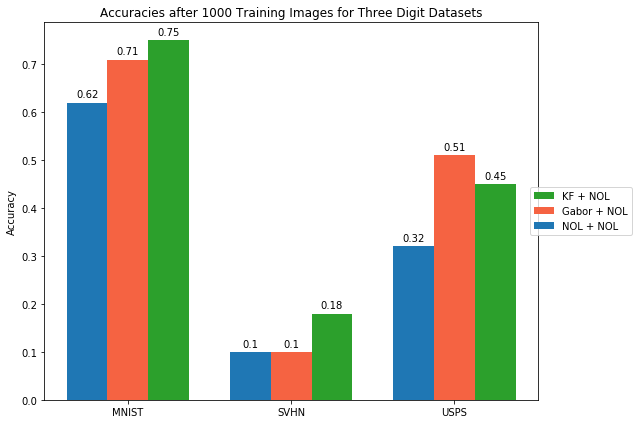

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 6)
rects=[]
positions = np.arange(3)
width = 0.25
for i, column in enumerate(df.columns.tolist()):
    rects.append(ax.bar(positions-((width)*i), np.round(np.array(df[column]),2), width=width, label=column,
                        color=colordict[column]))

ax.set_ylabel('Accuracy')
ax.set_title('Accuracies after 1000 Training Images for Three Digit Datasets')
ax.legend(loc='center right', bbox_to_anchor=(1.2,.5))
fig.tight_layout()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for rect in rects:
    autolabel(rect)
ax.set_xticks(positions-width)
ax.set_xticklabels(df.index.tolist())
fig.show()

In [33]:
buildData=False
datadir = '/home/ephy/Projects/tda_convolution/data/original/CIFAR/cifar-10-batches-py/'
if buildData:
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    train_X = list()
    train_y = list()
    for batch in os.listdir(datadir):
        if 'data_batch' in batch:
            resp = unpickle(datadir+batch)
            for i, item in enumerate(resp[b'data'].reshape(-1,3,32,32)):
                train_X.append(np.moveaxis(item,0,-1)/255)
                train_y.append(resp[b'labels'][i])
    train_X = np.array(train_X)
    train_y = np.array(train_y)

    test_X = list()
    test_y = list()
    resp=unpickle(datadir+'test_batch')
    for i, item in enumerate(resp[b'data'].reshape(-1,3,32,32)):
        test_X.append(np.moveaxis(item,0,-1)/255)
        test_y.append(resp[b'labels'][i])

    test_X = np.array(test_X)
    test_y = np.array(test_y)

    # Go ahead and gray scale these
    test_X = np.dot(test_X[...,:3], [0.299, 0.587, 0.114])
    train_X = np.dot(train_X[...,:3], [0.299, 0.587, 0.114])

    nClasses=len(np.unique(train_y))
    test_y = np.array([np.eye(nClasses)[x] for x in test_y])
    train_y = np.array([np.eye(nClasses)[x] for x in train_y])
    
    np.save('../data/altered/CIFAR/train_X' , train_X)
    np.save('../data/altered/CIFAR/train_y' , train_y)
    np.save('../data/altered/CIFAR/test_X' , test_X)
    np.save('../data/altered/CIFAR/test_y' , test_y)
    
train_X=np.load('../data/altered/CIFAR/train_X.npy' )
train_y=np.load('../data/altered/CIFAR/train_y.npy' )
test_X=np.load('../data/altered/CIFAR/test_X.npy' )
test_y=np.load('../data/altered/CIFAR/test_y.npy' )
    
train_X = torch.tensor(train_X, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

cifar_train_cats_X = np.array(train_X)[np.all(np.array(train_y)==np.eye(10)[3], axis=1)]
cifar_train_dogs_X = np.array(train_X)[np.all(np.array(train_y)==np.eye(10)[5], axis=1)]
cifar_test_cats_X = np.array(test_X)[np.all(np.array(test_y)==np.eye(10)[3], axis=1)]
cifar_test_dogs_X = np.array(test_X)[np.all(np.array(test_y)==np.eye(10)[5], axis=1)]

cifar_cats_X = np.append(cifar_train_cats_X, cifar_test_cats_X,axis=0)
cifar_dogs_X = np.append(cifar_train_dogs_X, cifar_test_dogs_X,axis=0)

cifar_train_X = torch.tensor(np.append(cifar_cats_X, cifar_dogs_X,axis=0), dtype=torch.float32)
cifar_train_y = torch.tensor(np.append(np.tile(np.eye(2)[0],[6000,1]),np.tile(np.eye(2)[1],[6000,1]),axis=0), dtype=torch.float32)

shuff = np.arange(len(cifar_train_y))
np.random.shuffle(shuff)

cifar_train_X = cifar_train_X[shuff]
cifar_train_y = cifar_train_y[shuff]

In [34]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'
device = torch.device("cuda:0")

class DogsVSCats():
    IMG_SIZE = 32
    CATS = datadir + "original/kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = datadir + "original/kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 0}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])                  
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                            
                except Exception as e:
                    #print(str(e))
                    pass
                
        np.random.shuffle(self.training_data)
        np.save(datadir + "altered/catdog_training_data_32x32.npy", self.training_data)
        
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
training_data = np.load(datadir+"altered/catdog_training_data_32x32.npy", allow_pickle=True)

X = np.array([i[0] for i in training_data])
kaggle_cd_X = X/255.0
kaggle_cd_y = np.array([i[1] for i in training_data])
kaggle_cd_X = kaggle_cd_X.astype(np.float32)
kaggle_cd_y = kaggle_cd_y.astype(np.float32)

kaggle_cd_X = torch.tensor(kaggle_cd_X)
kaggle_cd_y = torch.tensor(kaggle_cd_y)

In [35]:
cifar_to_kaggle_configs = copy.deepcopy(configs)
for key, config in cifar_to_kaggle_configs.items():
    config['classes']=2
    config['test_X']=kaggle_cd_X
    config['test_y']=kaggle_cd_y
    config['train_y']=cifar_train_y
    config['train_X']=cifar_train_X
    config['batchesPerTest']=20
    config['imageDim']=(32,32)
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR -> Kaggle'

In [36]:
results['CIFAR -> Kaggle'] = topnet.run_configs(cifar_to_kaggle_configs, None)

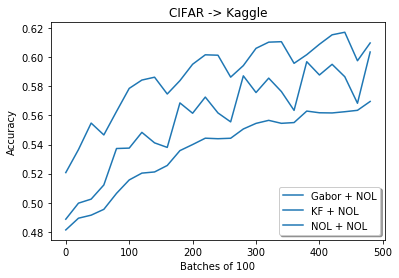

In [37]:
dataset='CIFAR -> Kaggle'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], 
             label=name,color=colordict[column])  
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [38]:
kaggle_to_cifar_configs = copy.deepcopy(cifar_to_kaggle_configs)
for name, config in kaggle_to_cifar_configs.items():
    config['train_X']=kaggle_cd_X
    config['train_y']=kaggle_cd_y
    config['test_y']=cifar_train_y
    config['test_X']=cifar_train_X
    config['dataset']='Kaggle -> CIFAR'

In [39]:
results['Kaggle -> CIFAR'] = topnet.run_configs(kaggle_to_cifar_configs, None)

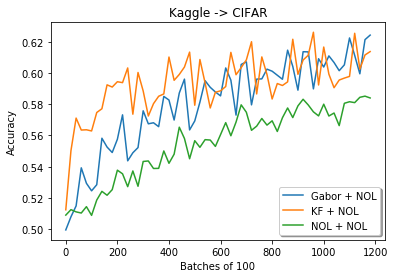

In [40]:
dataset='Kaggle -> CIFAR'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [41]:
c_train_X , c_test_X , c_train_y , c_test_y = train_test_split(np.array(cifar_train_X) , np.array(cifar_train_y), 
                                                test_size = 0.2 ,
                                                random_state = 1)

In [42]:
c_train_X  = torch.tensor(c_train_X, dtype=torch.float)
c_test_X  = torch.tensor(c_test_X, dtype=torch.float)
c_train_y  = torch.tensor(c_train_y, dtype=torch.float)
c_test_y = torch.tensor(c_test_y, dtype=torch.float)

In [43]:
cifar_configs = copy.deepcopy(configs)
for key, config in cifar_configs.items():
    config['classes']=2
    config['test_X']=c_test_X
    config['test_y']=c_test_y
    config['train_y']=c_train_y
    config['train_X']=c_train_X
    config['batchesPerTest']=20
    config['imageDim']=(32,32)
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR'

In [44]:
results['CIFAR'] = topnet.run_configs(cifar_configs, None)

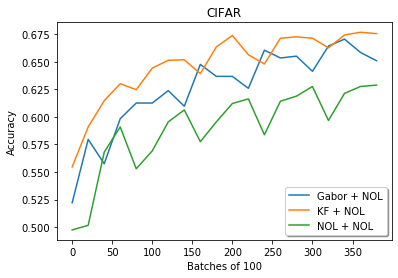

In [45]:
dataset='CIFAR'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [46]:
k_train_X , k_test_X , k_train_y , k_test_y = train_test_split(np.array(kaggle_cd_X) , np.array(kaggle_cd_y), 
                                                test_size = 0.2 ,
                                                random_state = 1)

In [47]:
k_train_X  = torch.tensor(k_train_X, dtype=torch.float)
k_test_X  = torch.tensor(k_test_X, dtype=torch.float)
k_train_y  = torch.tensor(k_train_y, dtype=torch.float)
k_test_y = torch.tensor(k_test_y, dtype=torch.float)

In [48]:
kaggle_configs = copy.deepcopy(cifar_configs)
for key, config in kaggle_configs.items():
    config['classes']=2
    config['test_X']=k_test_X
    config['test_y']=k_test_y
    config['train_y']=k_train_y
    config['train_X']=k_train_X
    config['dataset']='Kaggle'

In [49]:
results['Kaggle'] = topnet.run_configs(kaggle_configs, None)

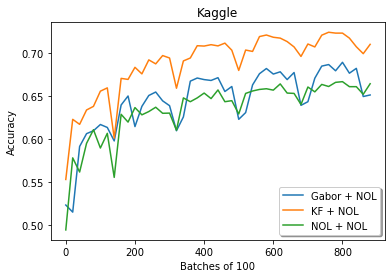

In [50]:
dataset='Kaggle'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],item['accuracies'], label=name)    
plt.ylabel('Accuracy')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [64]:
datasets = ['MNIST', 'SVHN', 'USPS', 'Kaggle', 'CIFAR']
accdat = dict()
for dataset in datasets:
    configuration=results[dataset]
    acc_2000=[]
    for name, item in configuration.items():
        acc_2000.append(item['accuracies'][int(1000/(item['config']['batchesPerTest']*item['config']['batchSize']) - 1)])
    accdat[dataset]=acc_2000
dataset=datasets[2]
configuration=results[dataset]
acc_2000_2=[]
names=[]
for name, item in configuration.items():
    names.append(name)

In [65]:
df = pd.DataFrame(data=accdat)
df = df.transpose()
df.columns =names

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


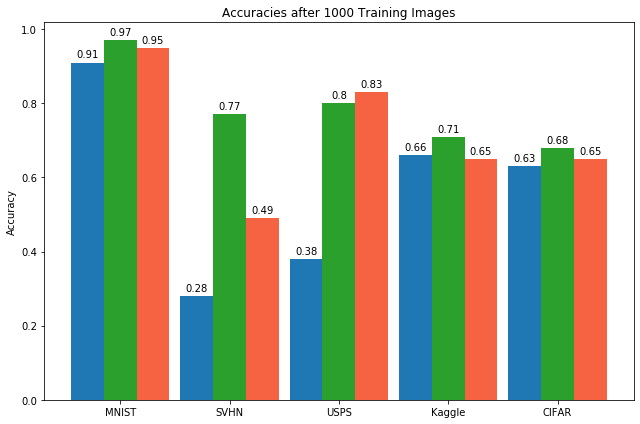

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 6)
rects=[]
positions = np.arange(5)
width = 0.3
for i, column in enumerate(df.columns.tolist()):
    rects.append(ax.bar(positions-((width)*i), np.round(np.array(df[column]),2), width=width, label=column,
                        color=colordict[column]))

ax.set_ylabel('Accuracy')
ax.set_title('Accuracies after 1000 Training Images')
# ax.legend(loc='center right', bbox_to_anchor=(1.2,.5))
fig.tight_layout()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for rect in rects:
    autolabel(rect)
ax.set_xticks(positions-width)
ax.set_xticklabels(df.index.tolist())
fig.show()

In [73]:
fig.savefig('/home/ephy/Projects/tda_convolution/fig/accuraciesAt1000_allDatasets.png', dpi=300, bbox_inches='tight')

In [80]:
datasets = ['MNIST', 'SVHN', 'USPS', 'Kaggle', 'CIFAR']
accdat = dict()
for dataset in datasets:
    configuration=results[dataset]
    acc_2000=[]
    for name, item in configuration.items():
        acc_2000.append(item['accuracies'][len(item['accuracies'])-1])
    accdat[dataset]=acc_2000
dataset=datasets[2]
configuration=results[dataset]
acc_2000_2=[]
names=[]
for name, item in configuration.items():
    names.append(name)

In [81]:
df = pd.DataFrame(data=accdat)
df = df.transpose()
df.columns =names

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]
/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


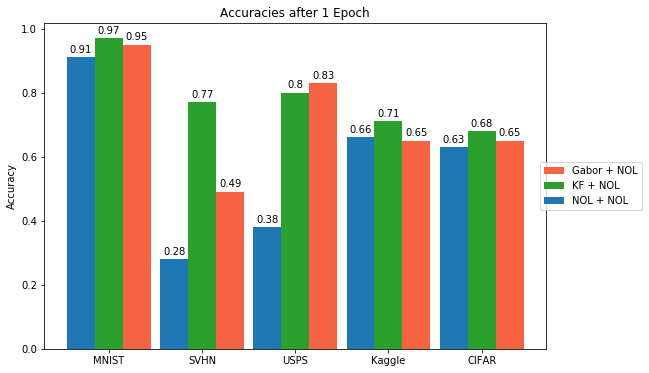

In [84]:
fig1, ax = plt.subplots()
fig1.set_size_inches(9, 6)
rects=[]
positions = np.arange(5)
width = 0.3
for i, column in enumerate(df.columns.tolist()):
    rects.append(ax.bar(positions-((width)*i), np.round(np.array(df[column]),2), width=width, label=column,
                        color=colordict[column]))

ax.set_ylabel('Accuracy')
ax.set_title('Accuracies after 1 Epoch')
ax.legend(loc='center right', bbox_to_anchor=(1.2,.5))
fig.tight_layout()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for rect in rects:
    autolabel(rect)
ax.set_xticks(positions-width)
ax.set_xticklabels(df.index.tolist())
fig1.show()

In [85]:
fig1.savefig('/home/ephy/Projects/tda_convolution/fig/accuraciesAt1epoch_allDatasets.png', dpi=300, bbox_inches='tight')

# 3D gabor

In [134]:
#Match settings of paper
thetas = [0,45,90,135]
phis = [0,45,90,135]
sigs = list(range(5))[1:]
# sigs=[3.6]

variables=[(t,p,s) for t in thetas for p in phis for s in sigs]
len(variables)

def gabor3D(gam,sig,the,phi,x,y,z):
    xp = x*np.sin(the)*np.cos(phi)
    yp = y*np.sin(the)*np.cos(phi)
    zp = z*np.cos(the)
    return(np.exp(- (x**2 + y**2 + z**2)/(2*(sig**2)) ) * np.cos(2*np.pi*(xp+yp+zp)/gam))
    
gam=5.6 
sig=5
the=np.deg2rad(45)
phi=np.deg2rad(45)
k=(len(variables), 7,7,3)

M = np.zeros(k)
for f,(the,phi,sig) in enumerate(variables):
    the = np.deg2rad(the)
    phi = np.deg2rad(phi)
    for x in range(M.shape[1]):
        for y in range(M.shape[2]):
            for z in range(M.shape[3]):
                M[f,x,y,z]=gabor3D(gam,sig,the,phi,x-(M.shape[1]/2),y-(M.shape[2]/2),z-(M.shape[3]/2))